<a href="https://colab.research.google.com/github/elaineortsac3/dio-lab-open-source/blob/main/Transfer_Learning_2_Elaine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning - Elaine

###1. Importando bibliotecas

In [1]:
#Limpa widgets interativos antigos, se existirem
from IPython.display import display
import ipywidgets as widgets

widgets.Widget.close_all()


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

###2. Carregar Dataset (Cats vs Dogs)

#https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

In [3]:
(train_data, test_data), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.P99AB9_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


###3. Pré-processar dados

- Ajuste do tamanho das imagens, normalização de pixels, agrupar em lotes

In [4]:
IMG_SIZE = 224 #VGG16 espera 224x224

def format_example(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0 #normalização
  return image, label

BATCH_SIZE = 32

train_batches = (train_data
                   .map(format_example)
                   .shuffle(1000)
                   .batch(BATCH_SIZE)
                   .prefetch(1))
val_batches = (test_data
                 .map(format_example)
                 .batch(BATCH_SIZE)
                 .prefetch(1))

##4. Carregar o modelo VGG16 pré-treinado

In [5]:
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   include_top=False, #removi a última camada (1000 classes)
                   weights='imagenet')

base_model.trainable = False #congelei o modelo

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###5. Criar o modelo completo (com nova cabeça)

In [6]:
model = models.Sequential([
                           base_model,
                           layers.Flatten(),
                           layers.Dense(256, activation= 'relu'),
                           layers.Dropout(0.5),
                           layers.Dense(1, activation='sigmoid')
                           ])

###6. Compliar e treinar o modelo

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                     epochs=5, #Para teste rodei com 2 porque estava travando depois de horas
                     validation_data=val_batches)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 165s 256ms/step - accuracy: 0.8493 - loss: 0.3262 - val_accuracy: 0.9282 - val_loss: 0.1702
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 190s 257ms/step - accuracy: 0.9302 - loss: 0.1749 - val_accuracy: 0.9304 - val_loss: 0.1583
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 151s 256ms/step - accuracy: 0.9450 - loss: 0.1399 - val_accuracy: 0.9359 - val_loss: 0.1528
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 136s 232ms/step - accuracy: 0.9523 - loss: 0.1200 - val_accuracy: 0.9353 - val_loss: 0.1509
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 149s 254ms/step - accuracy: 0.9648 - loss: 0.0977 - val_accuracy: 0.9355 - val_loss: 0.1524


###7. Avaliar e visualizar os resultados

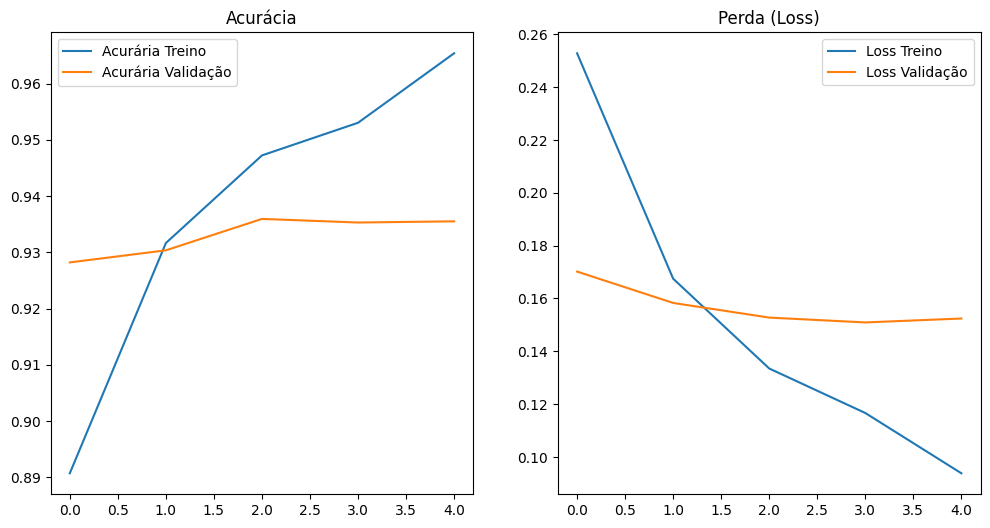

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Acurária Treino')
plt.plot(epochs_range, val_acc, label='Acurária Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(122)
plt.plot(epochs_range, loss, label='Loss Treino')
plt.plot(epochs_range, val_loss, label='Loss Validação')
plt.legend()
plt.title('Perda (Loss)')
plt.show()